In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier


df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
missing_val = df.isnull().sum()
print(missing_val)


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [2]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors = 'coerce')

In [3]:
df['TotalCharges'].isnull().sum()

np.int64(11)

In [4]:
df = df.dropna(subset=['TotalCharges'])
df.shape

(7032, 21)

In [6]:
df_clean = df.copy()

# Fix TotalCharges type
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')
df_clean['TotalCharges'] = df_clean['TotalCharges'].fillna(df_clean['TotalCharges'].median())

# Fix binary columns
binary_map = {'Yes': 1, 'No': 0}

binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df_clean[col] = df_clean[col].map(binary_map)

# Gender + SeniorCitizen
df_clean['gender'] = df_clean['gender'].map({'Male':1, 'Female':0})
df_clean['SeniorCitizen'] = df_clean['SeniorCitizen'].astype(int)

# DO NOT ONE-HOT ENCODE 'Churn' (target stays separate)
df_clean['Churn'] = df_clean['Churn'].map(binary_map)

# Multi-class categorical columns
multi_cols = [
    'InternetService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaymentMethod'
]

# IMPORTANT: drop_first=False to match Streamlit app
df_clean = pd.get_dummies(df_clean, columns=multi_cols, drop_first=False)

df_clean.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,0,1,0,1,0,1,29.85,29.85,...,True,False,False,True,False,False,False,False,True,False
1,5575-GNVDE,1,0,0,0,34,1,0,56.95,1889.50,...,True,False,False,False,True,False,False,False,False,True
2,3668-QPYBK,1,0,0,0,2,1,1,53.85,108.15,...,True,False,False,True,False,False,False,False,False,True
3,7795-CFOCW,1,0,0,0,45,0,0,42.30,1840.75,...,True,False,False,False,True,False,True,False,False,False
4,9237-HQITU,0,0,0,0,2,1,1,70.70,151.65,...,True,False,False,True,False,False,False,False,True,False


In [8]:
bool_cols = df_clean.select_dtypes(include=['bool']).columns
df_clean[bool_cols] = df_clean[bool_cols].astype(int)


In [9]:
print(df_clean.columns)

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'InternetService_Fiber optic',
       'InternetService_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No internet service',
       'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')


In [10]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             7032 non-null   object 
 1   gender                                 7032 non-null   int64  
 2   SeniorCitizen                          7032 non-null   int64  
 3   Partner                                7032 non-null   int64  
 4   Dependents                             7032 non-null   int64  
 5   tenure                                 7032 non-null   int64  
 6   PhoneService                           7032 non-null   int64  
 7   PaperlessBilling                       7032 non-null   int64  
 8   MonthlyCharges                         7032 non-null   float64
 9   TotalCharges                           7032 non-null   float64
 10  Churn                                  7032 non-null   int64  
 11  InternetS

In [7]:
X = df_clean.drop('Churn', axis=1)
y = df_clean['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((5625, 41), (1407, 41))

In [42]:
class_weight = {0:1, 1:3}
model = RandomForestClassifier(class_weight=class_weight)

In [43]:
# model.fit(X_train, y_train)
# y_pred_proba = model.predict_proba(X_test)[:,1]
# y_pred = (y_pred_proba > 0.35).astype(int)


In [44]:
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred))

# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

Confusion Matrix:
[[826 207]
 [132 242]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1033
           1       0.54      0.65      0.59       374

    accuracy                           0.76      1407
   macro avg       0.70      0.72      0.71      1407
weighted avg       0.78      0.76      0.77      1407



In [24]:
# model = LogisticRegression(class_weight='balanced', max_iter=200)


In [25]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE()
# X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


In [ ]:
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred))

# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

In [49]:

# rf = RandomForestClassifier(
#     n_estimators=200,
#     max_depth=None,
#     random_state=42,
#     class_weight='balanced'   

# rf.fit(X_train, y_train)
# y_pred_rf = rf.predict(X_test)

# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred_rf))
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred_rf))

Confusion Matrix:
[[924 109]
 [191 183]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.78      0.79      0.78      1407



In [51]:
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_tuned = RandomizedSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced'),
    param_distributions=param_grid,
    n_iter=20,
    cv=3,
    scoring='f1_macro',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rf_tuned.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


,estimator,RandomForestC...ht='balanced')
,param_distributions,"{'bootstrap': [True, False], 'max_depth': [None, 5, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,n_iter,20
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [8]:

# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred_rf))
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred_rf))

In [9]:
negative = sum(y_train == 0)
positive = sum(y_train == 1)

scale_pos_weight = negative / positive
scale_pos_weight


2.762541806020067

In [60]:
# We tuned the classification threshold for XGBoost to prioritize customer retention.
# At threshold 0.30, churn recall increased from 0.71 to 0.82, enabling early identification of 82% of potential churners. Although this increased false positives, the business cost of missing a churn customer is significantly higher than contacting a non-churn customer. Therefore, threshold 0.30 was selected as the optimal operational point.

In [11]:
X_train.dtypes

customerID                                  object
gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
InternetService_DSL                           bool
InternetService_Fiber optic                   bool
InternetService_No                            bool
MultipleLines_No                              bool
MultipleLines_No phone service                bool
MultipleLines_Yes                             bool
OnlineSecurity_No                             bool
OnlineSecurity_No internet service            bool
OnlineSecurity_Yes                            bool
OnlineBackup_No                

In [12]:
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')


In [13]:
X_train.isna().sum()


customerID                                 5625
gender                                        0
SeniorCitizen                                 0
Partner                                       0
Dependents                                    0
tenure                                        0
PhoneService                                  0
PaperlessBilling                              0
MonthlyCharges                                0
TotalCharges                                  0
InternetService_DSL                           0
InternetService_Fiber optic                   0
InternetService_No                            0
MultipleLines_No                              0
MultipleLines_No phone service                0
MultipleLines_Yes                             0
OnlineSecurity_No                             0
OnlineSecurity_No internet service            0
OnlineSecurity_Yes                            0
OnlineBackup_No                               0
OnlineBackup_No internet service        

In [14]:
print(X_train.shape)
print(X_train.head())


(5625, 41)
      customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
1413         NaN       1              0        1           1      65   
7003         NaN       1              0        0           0      26   
3355         NaN       0              0        1           0      68   
4494         NaN       1              0        0           0       3   
3541         NaN       0              0        1           0      49   

      PhoneService  PaperlessBilling  MonthlyCharges  TotalCharges  ...  \
1413             1                 0           94.55       6078.75  ...   
7003             0                 0           35.75       1022.50  ...   
3355             1                 0           90.20       6297.65  ...   
4494             1                 0           84.30        235.05  ...   
3541             0                 0           40.65       2070.75  ...   

      StreamingMovies_No  StreamingMovies_No internet service  \
1413                True                

In [15]:
X_train = X_train.drop("customerID", axis=1)
X_test = X_test.drop("customerID", axis=1)


In [17]:
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    max_depth=6,
    learning_rate=0.05,
    n_estimators=400,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [19]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.7, 0.8, 1],
    'colsample_bytree': [0.7, 0.8, 1]
}

xgb = XGBClassifier()

rs = RandomizedSearchCV(xgb, params, cv=3, n_iter=20, scoring='f1', n_jobs=-1)
rs.fit(X_train_scaled, y_train)

best_model = rs.best_estimator_


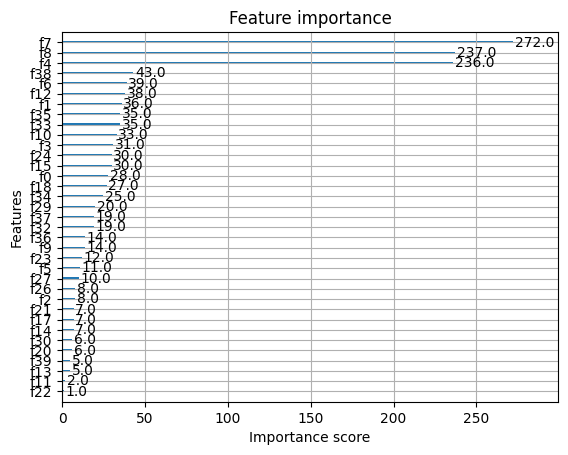

In [20]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(best_model)
plt.show()

In [20]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='f1')
scores.mean()


np.float64(0.5821783509657983)

In [21]:
y_pred = best_model.predict(X_test_scaled)


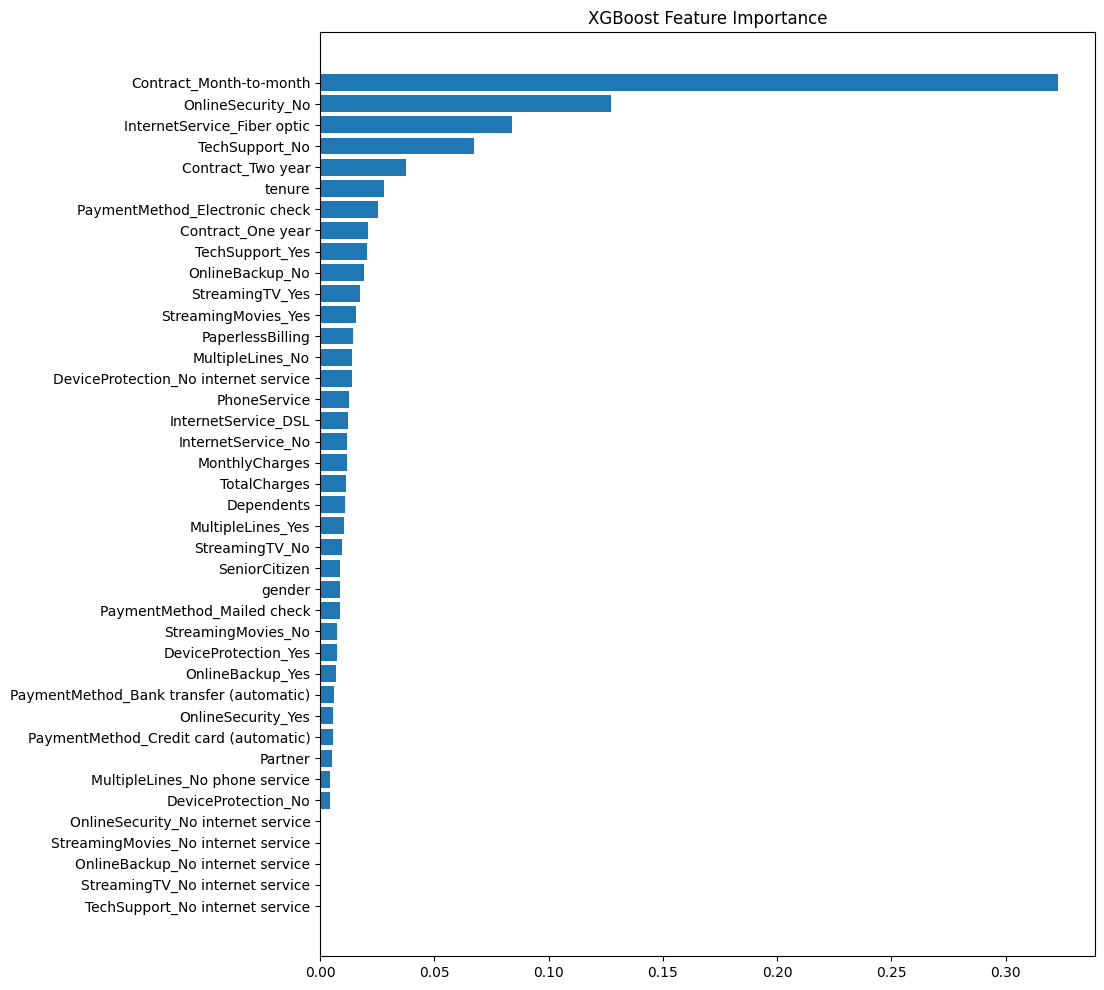

In [23]:
importances = best_model.feature_importances_
feature_names = X_train.columns

sorted_idx = importances.argsort()

plt.figure(figsize=(10,12))
plt.barh(feature_names[sorted_idx], importances[sorted_idx])
plt.title("XGBoost Feature Importance")
plt.show()


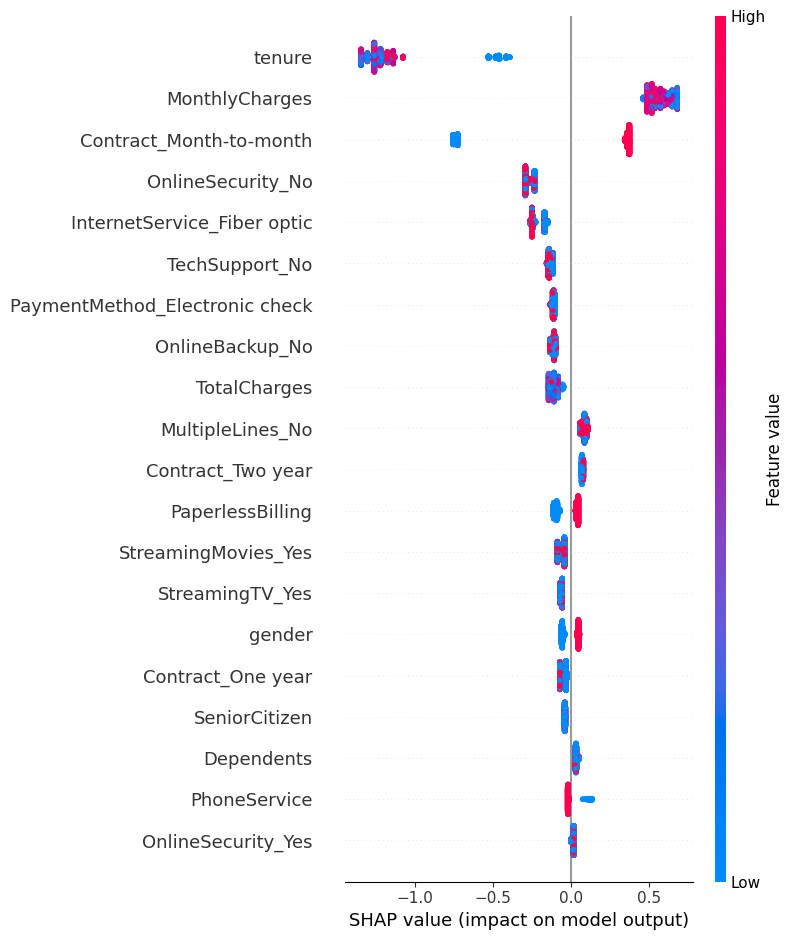

In [24]:
import shap
import numpy as np

# initialize JS visualization
shap.initjs()

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)


# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="dot")


In [26]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[919 114]
 [171 203]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1033
           1       0.64      0.54      0.59       374

    accuracy                           0.80      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.79      0.80      0.79      1407



In [28]:
def predict_churn(customer_row):
    prob = best_model.predict_proba(customer_row)[0][1]
    return prob


In [26]:
X_train_pred = best_model.predict_proba(X_train)[:, 1]
X_train_pred.max(), X_train_pred.min(), X_train_pred.mean()


(np.float32(0.2157084), np.float32(0.029972674), np.float32(0.07098803))

In [21]:
import joblib

# 1) Save the final best model
joblib.dump(best_model, "xgb_churn_model.pkl")

# 2) Save the exact columns used during training
joblib.dump(list(X_train.columns), "model_columns.pkl")

print("✔ Saved model as xgb_churn_model.pkl")
print("✔ Saved model columns as model_columns.pkl")


✔ Saved model as xgb_churn_model.pkl
✔ Saved model columns as model_columns.pkl


In [28]:
from sklearn.metrics import roc_curve

y_pred = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, y_pred)

best_threshold = thresh[(tpr - fpr).argmax()]
best_threshold


np.float32(0.07024008)

In [31]:
y_proba = best_model.predict_proba(X_test)[:, 1]

thresholds = [0.03, 0.05, 0.07, 0.10, 0.15]

for t in thresholds:
    print(f"\nThreshold = {t}")
    y_pred_t = (y_proba >= t).astype(int)
    print(confusion_matrix(y_test, y_pred_t))
    print(classification_report(y_test, y_pred_t))



Threshold = 0.03
[[125 908]
 [ 20 354]]
              precision    recall  f1-score   support

           0       0.86      0.12      0.21      1033
           1       0.28      0.95      0.43       374

    accuracy                           0.34      1407
   macro avg       0.57      0.53      0.32      1407
weighted avg       0.71      0.34      0.27      1407


Threshold = 0.05
[[569 464]
 [ 48 326]]
              precision    recall  f1-score   support

           0       0.92      0.55      0.69      1033
           1       0.41      0.87      0.56       374

    accuracy                           0.64      1407
   macro avg       0.67      0.71      0.62      1407
weighted avg       0.79      0.64      0.66      1407


Threshold = 0.07
[[569 464]
 [ 48 326]]
              precision    recall  f1-score   support

           0       0.92      0.55      0.69      1033
           1       0.41      0.87      0.56       374

    accuracy                           0.64      1407
   ma